# Network per channel

As we dive more precisely into the topic, we now create a more robust dataset:

* each input is an image of size `(C, W, H)`. On each channel, there is a grayscale sliced image. So, 
  * the first `C/3` channels are sliced images along x axis
  * the following `C/3` channels are sliced images along x axis
  * the last `C/3` channels are sliced images along x axis
* each output is list of fabric descriptors

If we take `C=3`, we can use a pretrained VGG model. Indeed, this model is trained on RGB images, which have 3 channels.

# Importing the dataframe

Firstly, we initialize wandb. It is a tool that allows to store the losses and retrieve the deframe. Otherwise, you can directly access locally the dataframe on your computer.

In [ ]:
!pip install wandb --upgrade

: 

We import all the useful packages.

In [ ]:
import sys
from pathlib import Path

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
if IS_KAGGLE:
    repo_path = Path("../input/microstructure-reconstruction")
elif IS_COLAB:
    from google.colab import drive

    drive.mount("/content/gdrive")
    repo_path = Path("/content/gdrive/MyDrive/microstructure-reconstruction")
else:
    repo_path = Path("/home/matias/microstructure-reconstruction")
sys.path.append(str(repo_path))

from copy import deepcopy
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
import pytorch_lightning as pl
import torch
from typing import Union, List
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import torchvision.models as pretrained_models
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from tqdm import tqdm

import wandb
from custom_datasets import dataset
from custom_models import models
from tools import dataframe_reformat, inspect_code, plotting, training, wandb_api

log_wandb = False

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 2, "pin_memory": True} if use_cuda else {"num_workers": 4}
print(f"[INFO]: Computation device: {device}")


[INFO]: Computation device: cpu


: 

We initialize a wandb run, that will save our metrics

In [ ]:
if log_wandb:
    import wandb

    wandb_api.login()
    run = wandb.init(
        project="microstructure-reconstruction",
        group="Gans",
        job_type="test",
    )


: 

Parameters of our run:

In [ ]:
if log_wandb:
    config = wandb.config
else:
    config = {}

config["job_type"] = run.job_type if "run" in locals() else "test"
config["train_val_split"] = 0.7
config["seed"] = 42
config["batch_size"] = 64
config["learning_rate"] = 0.001
config["device"] = device
config["architecture"] = "Autoencoder"
config["input_width"] = 64
config["epochs"] = 0
config["nb_image_per_axis"] = 1
config["latent_size"] = 1000
config["log_wandb"] = True
torch.manual_seed(config["seed"])
pl.seed_everything(config["seed"])


Global seed set to 42


42

: 

We retrieve the dataframe containing the descriptors. This can locally be done on your computer.

Nb of descriptors: 28
Nb batch in dataset: 20
Size of a batch: 64
Image shape: torch.Size([1, 64, 64])


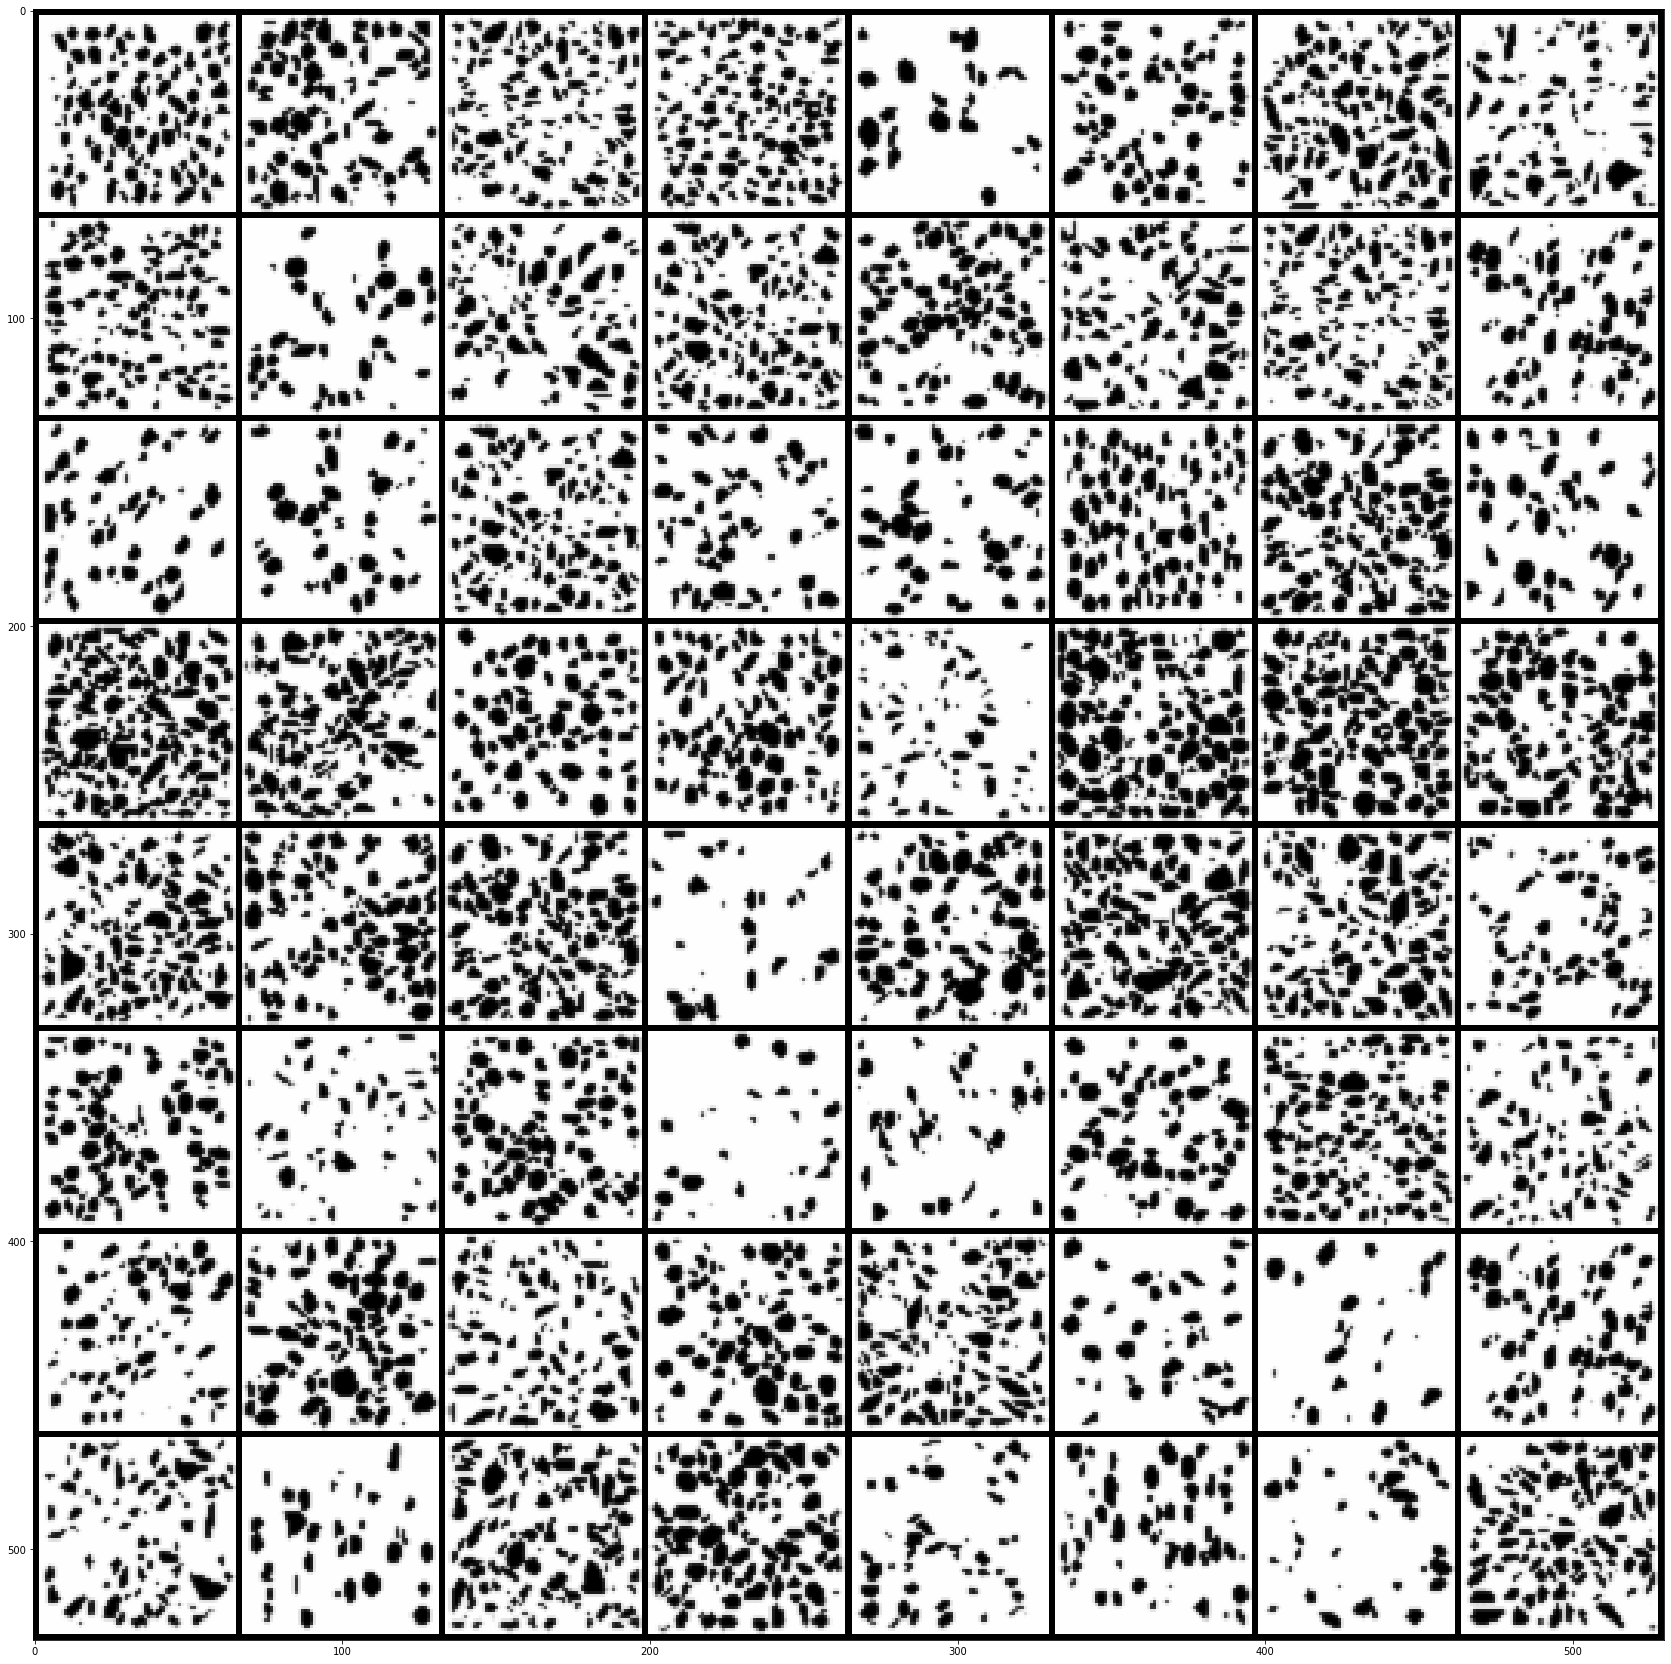

: 

In [ ]:
class DataModule(pl.LightningDataModule):
    def __init__(
        self,
        config,
        repo_path,
        train_df=None,
        test_df=None,
        train_dataset=None,
        validation_dataset=None,
    ):
        super().__init__()
        self.config = config
        self.repo_path = repo_path
        self.train_df = train_df.convert_dtypes() if train_df is not None else None
        self.test_df = test_df.convert_dtypes() if test_df is not None else None
        self.train_dataset = train_dataset
        self.validation_dataset = validation_dataset

        if self.config["log_wandb"]:
            if self.train_df is None:
                self.training_data_at = wandb.Api().artifact(
                    f"matiasetcheverry/microstructure-reconstruction/train_df:{self.config['nb_image_per_axis']}_images_invariants"
                )
            if self.test_df is None:
                self.test_data_at = wandb.Api().artifact(
                    f"matiasetcheverry/microstructure-reconstruction/test_df:{self.config['nb_image_per_axis']}_images_invariants"
                )

        self.transform = transforms.Compose(
            [
                transforms.GaussianBlur(kernel_size=3, sigma=0.5),
            ]
        )

    def prepare_data(self):
        if self.config["log_wandb"]:
            if self.train_df is None:
                self.training_data_at.download()
            if self.test_df is None:
                self.test_data_at.download()

    def _init_df_wandb(self):
        if self.train_df is None:
            self.train_df = wandb_api.convert_table_to_dataframe(
                self.training_data_at.get("fabrics")
            )
            self.train_df["photos"] = self.train_df["photos"].apply(
                func=lambda photo_paths: [
                    str(self.repo_path / Path(x)) for x in photo_paths
                ]
            )
        if self.test_df is None:
            self.test_df = wandb_api.convert_table_to_dataframe(
                self.test_data_at.get("fabrics")
            )
            self.test_df["photos"] = self.test_df["photos"].apply(
                func=lambda photo_paths: [
                    str(self.repo_path / Path(x)) for x in photo_paths
                ]
            )

    def _init_df_local(self):
        fabrics_df = pd.read_csv(self.repo_path / "REV1_600/fabrics.txt")
        path_to_slices = self.repo_path / "REV1_600/REV1_600Slices"
        fabrics_df["photos"] = fabrics_df["id"].apply(
            func=dataframe_reformat.associate_rev_id_to_its_images,
            args=(path_to_slices, self.config["nb_image_per_axis"]),
        )
        fabrics_df = fabrics_df[fabrics_df.photos.str.len().gt(0)]
        fabrics_df["photos"] = fabrics_df["photos"].apply(func=lambda x: sorted(x))
        train_df, test_df = train_test_split(
            fabrics_df,
            train_size=config["train_val_split"],
            random_state=config["seed"],
            shuffle=True,
        )
        if self.train_df is None:
            self.train_df = train_df.reset_index(drop=True)
        if self.test_df is None:
            self.test_df = test_df.reset_index(drop=True)

    def init_df(self):
        if self.config["log_wandb"]:
            self._init_df_wandb()
        else:
            self._init_df_local()

    def setup(self, stage):
        if self.train_dataset is None or self.validation_dataset is None:
            self.init_df()

            self.scaler = MinMaxScaler(feature_range=(0, 1))
            self.scaler.partial_fit(self.train_df.iloc[:, 1:-1])
            self.scaler.partial_fit(self.test_df.iloc[:, 1:-1])

            normalized_train_df = deepcopy(self.train_df)
            normalized_train_df.iloc[:, 1:-1] = self.scaler.transform(
                self.train_df.iloc[:, 1:-1]
            )
            normalized_test_df = deepcopy(self.test_df)
            normalized_test_df.iloc[:, 1:-1] = self.scaler.transform(
                self.test_df.iloc[:, 1:-1]
            )

            if self.train_dataset is None:
                self.train_dataset = dataset.SinglePhotoDataset(
                    normalized_train_df,
                    width=self.config["input_width"],
                    # nb_image_per_axis=config["nb_image_per_axis"],
                    transform=self.transform,
                    noise=0,
                )
            if self.validation_dataset is None:
                self.validation_dataset = dataset.SinglePhotoDataset(
                    normalized_test_df,
                    width=self.config["input_width"],
                    # nb_image_per_axis=config["nb_image_per_axis"],
                    transform=self.transform,
                    noise=0,
                )
            self.targets = self.test_df.iloc[:, 1:-1].to_numpy()

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.config["batch_size"],
            shuffle=True,
            **kwargs,
        )

    def val_dataloader(self):
        return DataLoader(
            self.validation_dataset,
            batch_size=self.config["batch_size"],
            shuffle=False,
            **kwargs,
        )

    def test_dataloader(self):
        return self.val_dataloader()

    def predict_dataloader(self):
        return DataLoader(
            [image for image, _ in self.validation_dataset],
            batch_size=self.config["batch_size"],
            shuffle=False,
            **kwargs,
        )


dm = DataModule(config, repo_path)
dm.prepare_data()
dm.setup(stage="fit")
first_batch = next(iter(dm.train_dataloader()))
print("Nb of descriptors:", len(first_batch[1][0]))
print("Nb batch in dataset:", len(dm.train_dataloader()))
print("Size of a batch:", len(first_batch[0]))
images, labels = first_batch[0], first_batch[1]
print("Image shape:", images[0].shape)
grid = utils.make_grid(images)
fig = plt.figure(figsize=(90, 30))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.show()


# Network definition

The next step is to define our model. This model is inspired by VGG11:

* we define several convulational blocks.
* each of this block is sequence of:
  * convulational layer with `kernel_size=3, padding=1`
  * activation function, here it is the `ReLU`
  * max pooling layer with `kernel_size=2, stride=2` which aims at reducing the size of the convolutional layers

In [ ]:
class Encoder(nn.Module):
    def __init__(
        self,
        config,
    ):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 256, kernel_size=5, stride=3, padding=0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 126, kernel_size=5, stride=3, padding=0),
            nn.BatchNorm2d(126),
            nn.LeakyReLU(),
            nn.Conv2d(126, 64, kernel_size=5, stride=3, padding=0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Flatten(),
        )
        _, length = self.model(
            torch.rand(
                (
                    config["batch_size"],
                    1,
                    config["input_width"],
                    config["input_width"],
                )
            )
        ).shape
        self.output = nn.Linear(
            length,
            config["latent_size"],
        )

    def forward(self, img):
        x = self.model(img)
        return self.output(x)


descriptors = first_batch[1]
images = first_batch[0]
d = Encoder(config)
print(d(images).shape)
total_params = sum(p.numel() for p in d.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
# g = Generator(config)
# print(g(descriptors).shape)
# total_params = sum(p.numel() for p in g.parameters())
# print(f"[INFO]: {total_params:,} total parameters.")


torch.Size([64, 1000])
[INFO]: 4,357,282 total parameters.


: 

In [ ]:
class Decoder(nn.Module):
    def __init__(self, config, latent_dim=28):
        super(Decoder, self).__init__()

        kernel_sizes = [3, 3, 3, 3, 4]
        strides = [1, 2, 2, 2, 2]
        paddings = [0, 0, 0, 0, 0]
        filters = [400, 512, 256, 64, 32]

        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                config["latent_size"],
                filters[1],
                stride=strides[0],
                kernel_size=kernel_sizes[0],
                padding=paddings[0],
            ),
            nn.BatchNorm2d(filters[1]),
            nn.ReLU(),
            nn.ConvTranspose2d(
                filters[1],
                filters[2],
                stride=strides[1],
                kernel_size=kernel_sizes[1],
                padding=paddings[1],
            ),
            nn.BatchNorm2d(filters[2]),
            nn.ReLU(),
            nn.ConvTranspose2d(
                filters[2],
                filters[3],
                stride=strides[2],
                kernel_size=kernel_sizes[2],
                padding=paddings[2],
            ),
            nn.BatchNorm2d(filters[3]),
            nn.ReLU(),
            nn.ConvTranspose2d(
                filters[3],
                filters[4],
                stride=strides[3],
                kernel_size=kernel_sizes[3],
                padding=paddings[3],
            ),
            nn.BatchNorm2d(filters[4]),
            nn.ReLU(),
            nn.ConvTranspose2d(
                filters[4],
                1,
                stride=strides[4],
                kernel_size=kernel_sizes[4],
                padding=paddings[4],
            ),
            nn.Tanh(),
        )

    def forward(self, z):
        z = torch.unsqueeze(torch.unsqueeze(z, -1), -1)
        img = self.model(z)
        return img


descriptors = first_batch[1]
images = first_batch[0]
d = Decoder(config)
print(d(torch.rand((config["batch_size"], config["latent_size"]))).shape)
total_params = sum(p.numel() for p in d.parameters())
print(f"[INFO]: {total_params:,} total parameters.")


torch.Size([64, 1, 64, 64])
[INFO]: 5,956,641 total parameters.


: 

In [ ]:
class Autoencoder(pl.LightningModule):
    def __init__(
        self,
        config,
    ):
        super().__init__()
        self.config = config

        self.encoder = Encoder(config)
        self.decoder = Decoder(config)

        self.configure_criterion()
        self.configure_metrics()

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def configure_criterion(self):
        self.criterion = nn.BCELoss(reduction="mean")
        self.config["loss_type"] = type(self.criterion)

    def configure_metrics(self):
        self.metrics = {
            "val_loss": self.criterion.to(self.config["device"]),
            "mse": nn.MSELoss(reduction="mean"),
        }

    def training_step(self, batch, batch_idx):
        img, _ = batch
        loss = self.criterion(img, self(img))
        self.log(
            "train_loss",
            loss,
            on_step=False,
            on_epoch=True,
        )
        return loss

    def validation_step(self, batch, batch_idx):
        img, _ = batch
        fake_img = self(img)
        metrics = {name: metric(img, fake_img) for name, metric in self.metrics.items()}
        self.log_dict(metrics, on_step=False, on_epoch=True, prog_bar=True)
        return metrics

    def training_epoch_end(self, outputs):
        self.config["epochs"] += 1


model = Autoencoder(config)
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
# model.training_step(first_batch, 1)


Autoencoder(
  (encoder): Encoder(
    (model): Sequential(
      (0): Conv2d(1, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2d(512, 256, kernel_size=(5, 5), stride=(3, 3))
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Conv2d(256, 126, kernel_size=(5, 5), stride=(3, 3))
      (7): BatchNorm2d(126, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01)
      (9): Conv2d(126, 64, kernel_size=(5, 5), stride=(3, 3))
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): LeakyReLU(negative_slope=0.01)
      (12): Flatten(start_dim=1, end_dim=-1)
    )
    (output): Linear(in_features=64, out_features=1000, bias=True)
  )
  (decoder): Dec

: 

# Checkpoint

We had 2 checkpoints to our training:

* one for saving our model every time we have a minimum in the validation loss 
* one for saving the model's and data module script

In [ ]:
reload(training)
# model_checkpoint = pl.callbacks.model_checkpoint.ModelCheckpoint(
#     dirpath=run.dir if "run" in locals() else "tmp/",
#     filename="{epoch}-{val_loss:.3f}",
#     monitor="val_loss",
#     mode="min",
#     verbose=True,
#     save_last=True,
# )

script_checkpoint = training.ScriptCheckpoint(
    dirpath=run.dir if "run" in locals() else "tmp/",
)
images_callback = training.AutoencoderGeneratedImagesCallback(
    images=first_batch[0].to(device), log_every_n_epochs=10
)
callbacks = [script_checkpoint, images_callback]
log = None
if config["job_type"] == "train":
    callbacks.append(model_checkpoint)
    print(f"[INFO]: saving models.")
else:
    print(f"[INFO]: not saving models.")
if config["job_type"] == "debug":
    log = "all"


[INFO]: not saving models.


: 

# Training

We then train our model.

In [ ]:
if config["log_wandb"]:
    wandb_logger = pl.loggers.WandbLogger()
    # wandb_logger.watch(model, log=log, log_graph=True)
else:
    wandb_logger = None
trainer = pl.Trainer(
    max_epochs=400,
    callbacks=callbacks,
    logger=wandb_logger,
    devices="auto",
    accelerator="auto",
    #     limit_train_batches=0.3,
    #     limit_val_batches=1,
    #     log_every_n_steps=1,
)
trainer.fit(
    model,
    datamodule=dm,
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/matias/.pyenv/versions/3.9.8/envs/gt/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(

  | Name      | Type    | Params
--------------------------------------
0 | encoder   | Encoder | 4.4 M 
1 | decoder   | Decoder | 6.0 M 
2 | criterion | BCELoss | 0     
--------------------------------------
10.3 M    Trainable params
0         Non-trainable params
10.3 M    Total params
41.256    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42
/home/matias/.pyenv/versions/3.9.8/envs/gt/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matiasetcheverry. Use `wandb login --relogin` to force relogin


: 

: 

: 

tensor([[0.1292, 0.0410, 0.0000, 0.4212, 0.1517, 0.2473, 0.2628, 0.7347, 0.9638,
         0.3629, 0.4554, 0.3451, 0.3618, 0.4400, 0.2887, 0.9165, 0.2915, 0.3429,
         0.4182, 0.5891, 0.7037, 0.4476, 0.2186, 0.5601, 0.7563, 0.4259, 0.6731,
         0.5412],
        [0.2787, 0.2352, 0.0000, 0.0410, 0.0076, 0.0149, 0.0121, 0.9859, 0.1590,
         0.3952, 0.5274, 0.1122, 0.0627, 0.1822, 0.1434, 0.1163, 0.0649, 0.2985,
         0.4037, 0.4553, 0.6588, 0.5089, 0.2168, 0.6334, 0.4972, 0.4407, 0.6275,
         0.3048],
        [0.8899, 0.9069, 0.0000, 0.9985, 0.9960, 0.6421, 0.6551, 0.3253, 0.2011,
         0.3159, 0.4341, 0.8678, 0.8819, 0.9510, 0.8557, 0.6886, 0.6986, 0.5090,
         0.8317, 0.5008, 0.7798, 0.5481, 0.0000, 0.9893, 0.0265, 0.8697, 0.8823,
         0.0154],
        [0.2626, 0.1205, 0.0000, 0.7971, 0.3935, 0.7291, 0.7152, 0.2486, 0.9286,
         0.5147, 0.6626, 0.7704, 0.7600, 0.4361, 0.2806, 0.8903, 0.7571, 0.3835,
         0.4757, 0.5048, 0.7544, 0.5380, 0.3784, 0.5294

: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([60, 3, 64, 64])


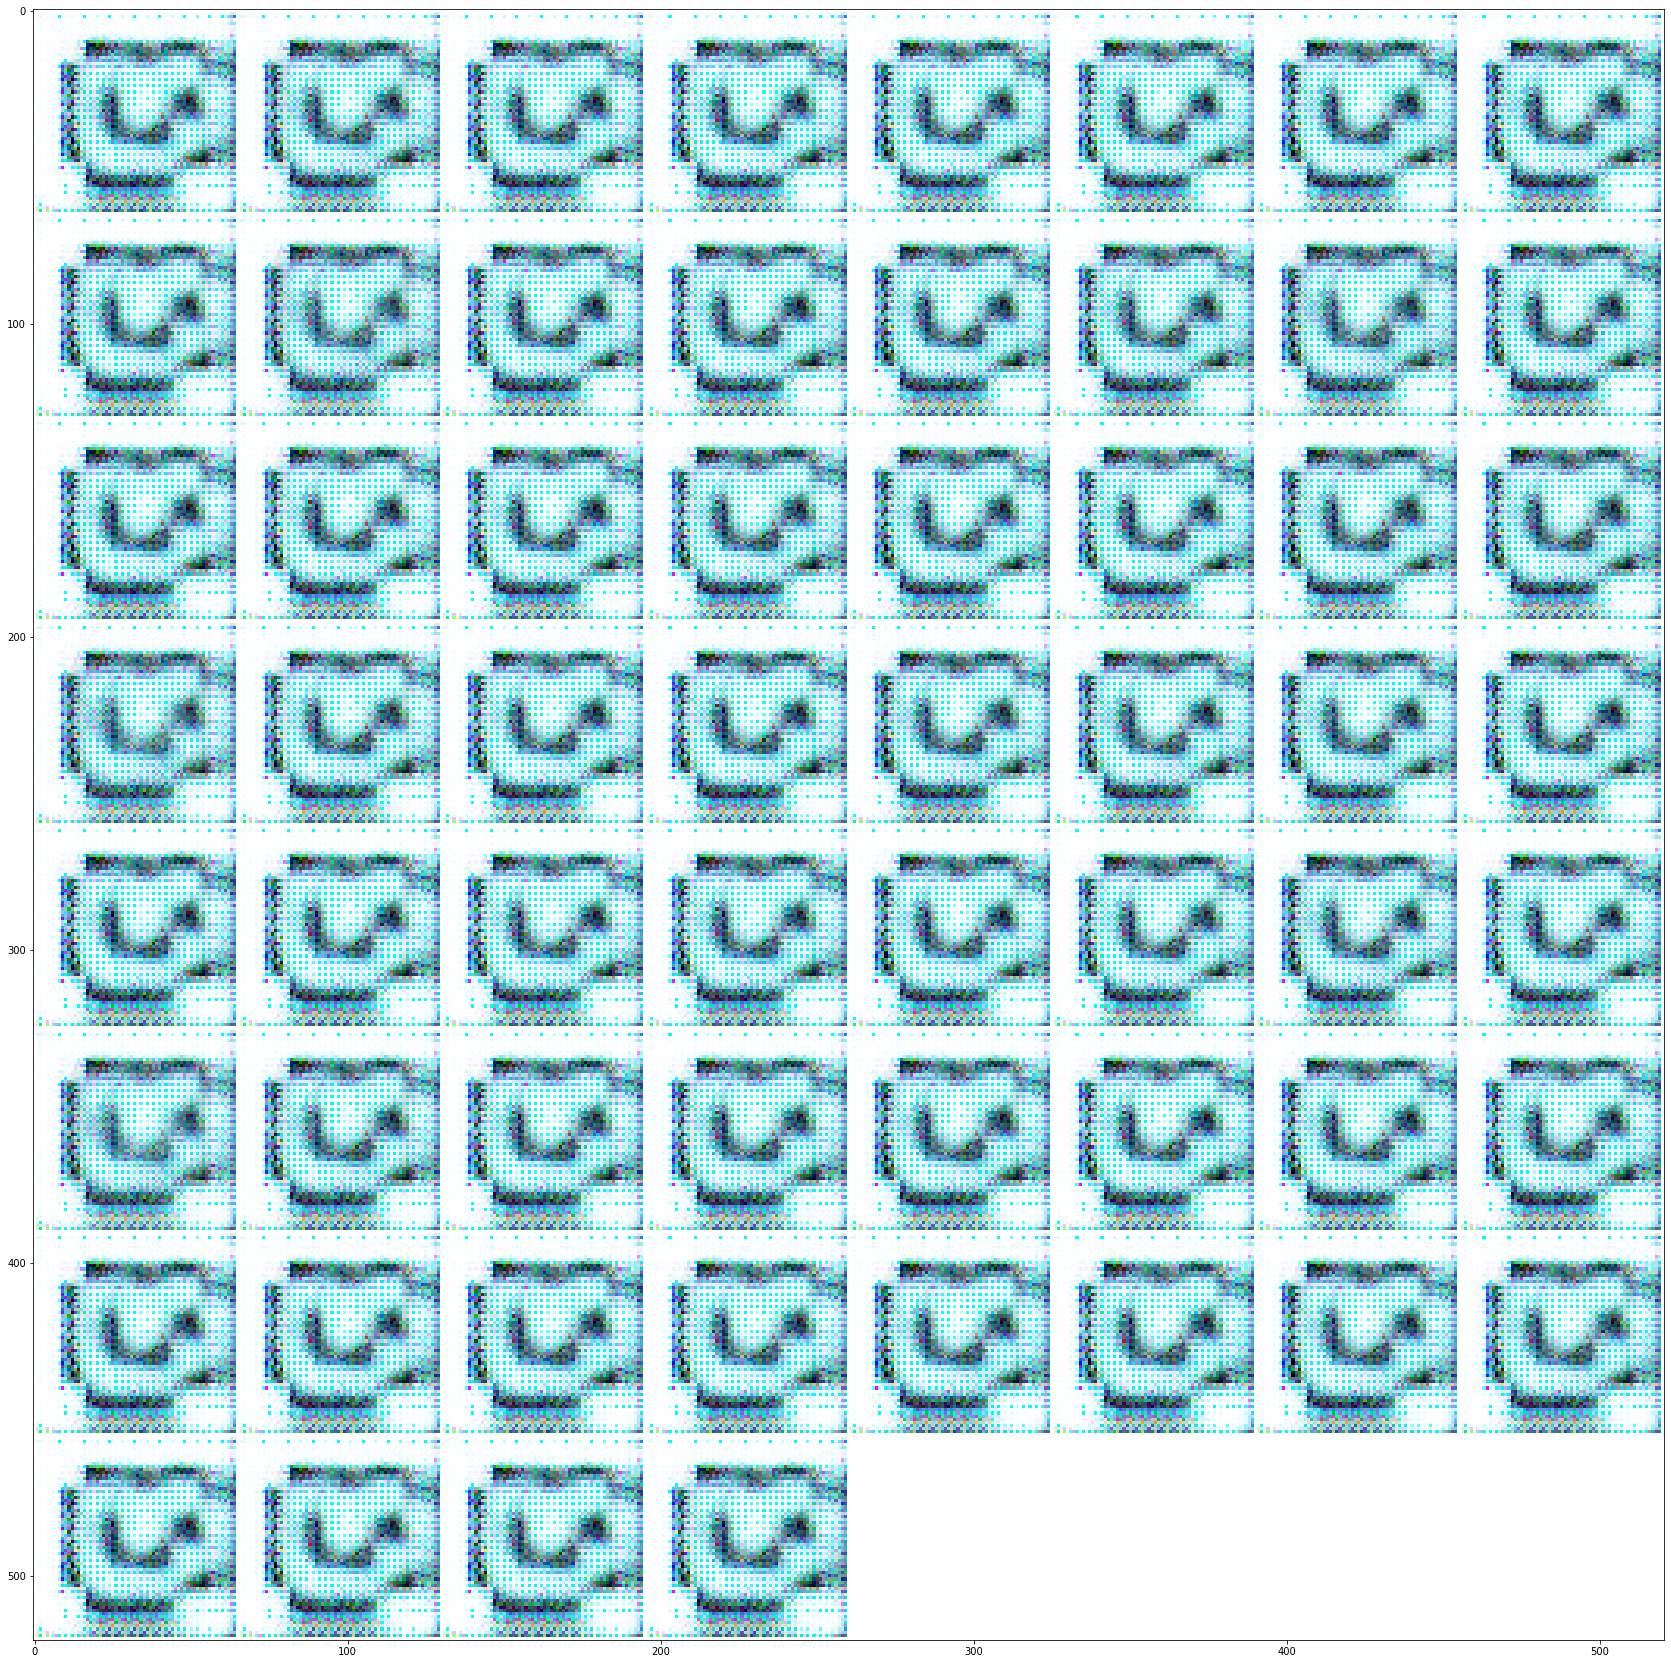

: 

In [ ]:
outputs = model(dm.validation_dataset[:60][1])
print(outputs.shape)
grid_img = utils.make_grid(outputs, normalize=False, pad_value=1, padding=1)
plt.figure(figsize=(30, 30))
plt.imshow(grid_img.permute(1, 2, 0))


In [ ]:
outputs[0, 0, 0], outputs[1, 0, 0]


(tensor([0.9932, 0.9670, 0.9991, 0.9870, 0.9988, 0.9993, 0.9908, 1.0000, 0.9995,
         0.9999, 0.9989, 0.9989, 0.9994, 0.9997, 0.9946, 0.9996, 0.9983, 0.9982,
         0.9961, 0.9964, 0.9971, 0.9986, 0.9862, 0.9984, 0.9985, 0.9990, 0.9964,
         0.9959, 0.9977, 0.9981, 0.9896, 0.9984, 0.9984, 0.9986, 0.9977, 0.9971,
         0.9980, 0.9983, 0.9912, 0.9988, 0.9976, 0.9984, 0.9952, 0.9962, 0.9982,
         0.9979, 0.9919, 0.9980, 0.9988, 0.9986, 0.9994, 0.9976, 0.9985, 0.9995,
         0.9871, 0.9994, 0.9991, 0.9998, 0.9807, 0.9970, 0.9466, 0.9784, 0.8168,
         0.8932], grad_fn=<SelectBackward0>),
 tensor([0.9909, 0.9605, 0.9986, 0.9843, 0.9984, 0.9990, 0.9898, 1.0000, 0.9993,
         0.9999, 0.9986, 0.9987, 0.9992, 0.9996, 0.9943, 0.9995, 0.9981, 0.9981,
         0.9955, 0.9962, 0.9971, 0.9984, 0.9864, 0.9982, 0.9985, 0.9988, 0.9966,
         0.9959, 0.9977, 0.9983, 0.9903, 0.9985, 0.9985, 0.9987, 0.9977, 0.9975,
         0.9979, 0.9984, 0.9906, 0.9988, 0.9976, 0.9984, 0.9949

: 

In [ ]:
dm.prepare_data()
dm.setup("validate")
predictions = torch.cat(trainer.predict(model, dataloaders=dm.predict_dataloader()))
targets = torch.FloatTensor(dm.targets)


/home/matias/.pyenv/versions/3.9.8/envs/gt/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  rank_zero_deprecation(


Predicting: 27it [00:00, ?it/s]

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [28, 128, 5, 5], but got 6-dimensional input of size [16, 3, 64, 64, 1, 1] instead

: 

In [ ]:
save_output = training.SaveOutput()
handle = model.layers[3].register_forward_hook(save_output)
image = images[0]
model(image.unsqueeze(0))
handle.remove()
outputs = save_output.outputs[0].permute(1, 0, 2, 3).detach().cpu()[:30]
grid_img = utils.make_grid(outputs, normalize=True, pad_value=1, padding=1)
plt.figure(figsize=(30, 30))
plt.imshow(grid_img.permute(1, 2, 0))


: 

In [ ]:
fig = plotting.plot_kde(
    [dm.scaler.transform(targets.cpu().numpy()), predictions.cpu().numpy()],
    nb_hist_per_line=6,
    columns=dm.train_df.columns[1:-1],
)


: 

In [ ]:
run.finish()


wandb: Network error (ConnectionError), entering retry loop.


d_loss,▃▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▇▂▂▂▂▂▅▂▃▄▁▂██
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
fake_discriminator,▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▂▂▁▁▁▁▂▃▃▄▄▃▃▄▅▅▆▇▇▇█
g_loss,▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▇▇████▇▆▆▅▅▆▆▅▄▄▃▂▂▂▁
penalty_discriminator,▄▃▂▂▃▃▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▂▆▂▁▁▁▁▄▄▂▂▁▂█▇
real_discriminator,▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▂▂▁▁▁▁▂▃▃▄▄▃▃▄▆▆▆█▇▇█
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
d_loss,28.92428
epoch,999
fake_discriminator,119.76459
g_loss,-119.65892


: 

: 